In [84]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm
from scipy.optimize import curve_fit
from mayavi import mlab
import time
import matplotlib.ticker as ticker


In [15]:
major = 7.5
minor = 3
width = 1.25
#plt.rcParams["figure.figsize"] = (5,4)
plt.rc('text', usetex=True)
plt.rc("axes", labelsize=13) # 18
plt.rc("xtick", labelsize=11, top=True, direction="in")
plt.rc("ytick", labelsize=11, right=True, direction="in")
plt.rc("axes", titlesize=13)
plt.rc("legend", fontsize=11)
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.linewidth'] = width
plt.rcParams['xtick.minor.width'] = width
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.minor.width'] = width
plt.rcParams['ytick.major.width'] = width
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

In [3]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [4]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2     # This choice should make things symmetric

In [5]:
def plot_M_grid(M_grid, px_list, pz_list, log=False, log_scale=1e-4, is_square=False, save=False):
    """
    Function to plot the calculated grids
    """
    plt.figure(facecolor='white', figsize=(12,6))

    if not is_square:
        M2_grid = np.abs(M_grid)**2
    else:
        M2_grid = M_grid.copy()

    MMax = np.max(M2_grid)

    if log:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', norm=LogNorm(vmin=MMax*log_scale, vmax=MMax),
                   interpolation = 'bicubic', aspect = 1.)
    else:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', interpolation = 'bicubic', aspect = 1.)

    plt.ylabel("$p_x$")
    plt.xlabel("$p_z$")
    plt.colorbar()
    if save:
        plt.savefig('M_plot.png', bbox_inches='tight')

    plt.show()


def plot_wavefunc(clm_array, iso=0.03, l=5, n=100):
    x, y, z = np.mgrid[-l:l:n*1j, -l:l:n*1j, -l:l:n*1j]
    mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
    orbital = np.real(se.eval_asymptotic_cart(x, y, z, clm_array, Ip))

    mlab.contour3d(orbital, contours=[iso], transparent=False, color=(1, 0, 0))
    mlab.contour3d(orbital, contours=[-iso], transparent=False, color=(0, 0, 1))
    mlab.show()


def load_lebedev(file_name):
    """
    Loads the quad-points to be used in Lebedev quad. integration
    """
    phi, theta, w = np.loadtxt('Lebedev/' + file_name + '.txt', skiprows=1, unpack=True)
    theta = np.deg2rad(theta)
    phi = np.deg2rad([phi_i if phi_i >= 0 else 360 + phi_i for phi_i in phi])
    return theta, phi, w

In [6]:
file_name = 'output_files/allene_align_Cl.out'
#center1 = np.array([-0.0006371178, -0.0012884863, 1.4927029103])
#center2 = np.array([-0.0005622321, -0.0001058155, 0.0015786766])
#center = (center1 + center2)/2
#print(center)
center = [0.0102200000, 0.0080900000, 1.2885300000]  # In Å
output = OutputInterface(file_name, shift_center=center)
orbital_nr = None

if orbital_nr == None:
    orbital_nr = output.HOMO
else:
    output.load_orbital(orbital_nr)

Ip = -output.saved_orbitals[orbital_nr][0]
kappa = np.sqrt(2*Ip)

In [6]:
output.HOMO

27

### Plot the f_lm's to find a good area for matching!

/home/mads/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/home/mads/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2821: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive
/home/mads/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:3141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


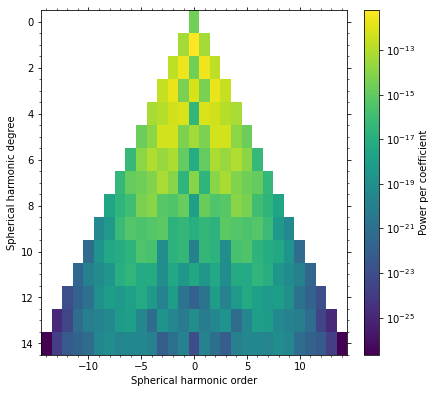

array([[[ 1.91900374e-07+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [-8.58740356e-06+0.00000000e+00j,
          4.81407270e-07+6.32201501e-07j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.000000

In [112]:
se.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(15., theta, phi, orbital_nr), 30, True)

In [9]:
plot_list = np.linspace(1, 16, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 30, orbital_nr=orbital_nr)

Evaluating at r=16.0000 	 Nr. 75/75

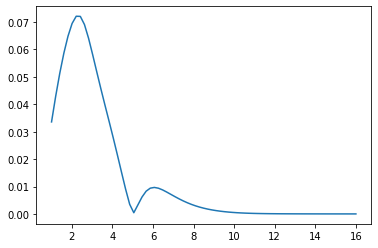

In [129]:
sign, l, m = 0, 2, 1

plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sign, l, m]), label='Laplace')
plt.show()

### Fit to the selected region to match Clm's

In [7]:
r_list = np.linspace(10, 12, 30)  # 8-10
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 30, Ip, orbital_nr=orbital_nr, threshold=1e-4)

Evaluating at r=12.0000 	 Nr. 30/30
Now fitting!
Done!


In [14]:
#np.save('data/allene_Cl_align/clm_array_10_12', clm_array)

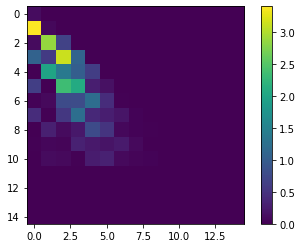

In [93]:
#for sign in range(2):
#    for l in range(0,15):
#        for m in range(l+1):
#            if l > 10:
#                clm_array[sign, l, m] = 0.

plt.imshow(np.abs(clm_array[0]))
plt.colorbar()

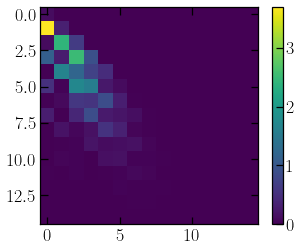

In [11]:
plt.imshow(np.abs(clm_array[0]))
plt.colorbar()

In [190]:
test_arr = np.vstack(clm_array[1], clm_array[0])
plt.imshow(np.abs(test_arr))

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

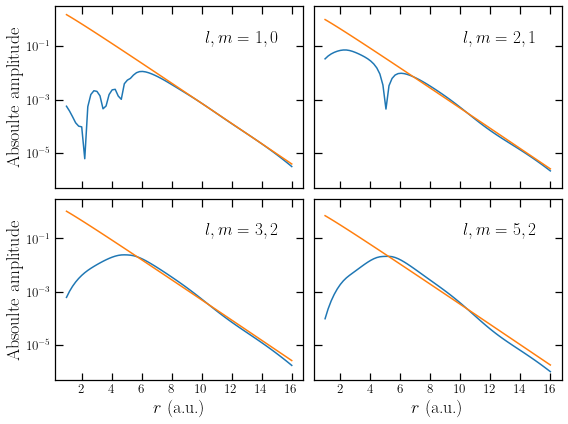

In [90]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sign, l, m = 0, 3, 2

to_plot = [[[0,1,0], [0,2,1]], [[0,3,2], [0,5,2]]]



major = 7.5
minor = 3
width = 1.25

plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.linewidth'] = width
plt.rcParams['xtick.minor.width'] = width
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.minor.width'] = width
plt.rcParams['ytick.major.width'] = width
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rc('text', usetex=True)
plt.rc("axes", labelsize=18) # 18
plt.rc("xtick", labelsize=13, top=True, direction="in")
plt.rc("ytick", labelsize=13, right=True, direction="in")
plt.rc("axes", titlesize=15)
plt.rc("legend", fontsize=11)

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,6))

for i, row in enumerate(to_plot):
    for j, lm in enumerate(row):
        sign, l, m = lm
        axs[i,j].plot(plot_list, np.abs(f_lms[:, sign, l, m]))#, label='Laplace')
        axs[i,j].plot(plot_list, np.abs(asymp(plot_list, clm_array[sign, l, m])))#, label='Asymp.')
        axs[i,j].set_yscale('log')

        axs[i,j].text(0.75, 0.8, f'$l,m = {l},{m}$', horizontalalignment='center',  transform=axs[i,j].transAxes, fontsize='xx-large')

        #plt.xlabel('$r$ (a.u.)')
        #plt.ylabel('Absolute amplitude')
axs[1,0].set_xlabel('$r$ (a.u.)')
axs[1,1].set_xlabel('$r$ (a.u.)')
axs[0,0].set_ylabel('Absoulte amplitude')
axs[1,0].set_ylabel('Absoulte amplitude')
fig.set_facecolor('white')

tick_spacing = 2.
axs[0,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [180]:
plot_wavefunc(clm_array,iso=0.001, l=10)

### Let's look at SFA results with this...

In [158]:
N = 75
pz_list = np.linspace(-1.5, 1.5, int(3/2*N))
px_list = np.linspace(-1, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

In [169]:
SP_asymp_martiny = SFA_Lin.SFALinearPulse(Ip, Up, omega, 5, CEP, target_="asymp_martiny")

In [170]:
M_grid = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))

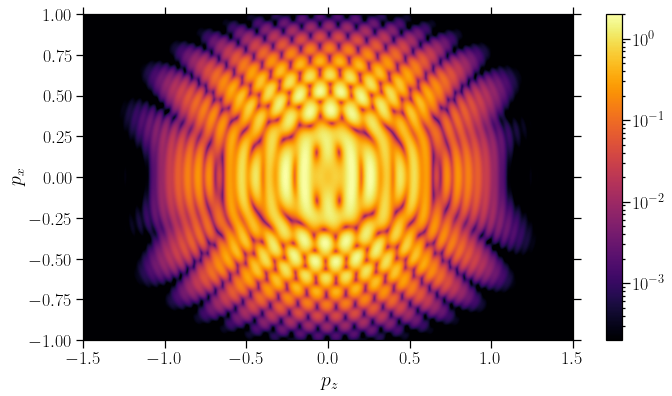

In [178]:
plot_M_grid(M_grid, px_list, pz_list, log=True, log_scale=1e-4, save=True)

### Dipole stuff

In [25]:
alpha_list = np.array([9.2989116E+00, -2.3143624E+01, 9.9025090E+01])
print(alpha_list)

[  9.2989116 -23.143624   99.02509  ]


In [26]:
SP_dip = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="dipole")

In [27]:
M_grid_dip = np.array(pool.starmap(SP_dip.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array), repeat(alpha_list))))

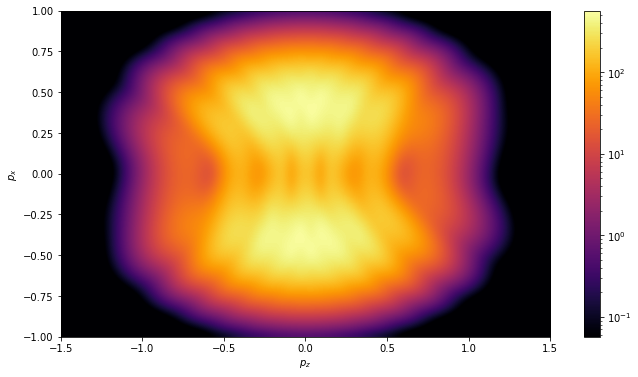

In [28]:
plot_M_grid(M_grid_dip, px_list, pz_list, log=True)

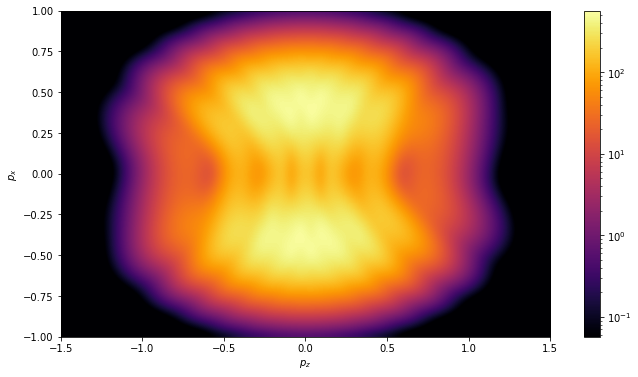

In [12]:
plot_M_grid(M_grid_dip, px_list, pz_list, log=True)

### Let's try the Stark shifted version!

In [10]:
mu_M = np.array([-5.8231348E-01, -3.9977011E-01, 9.5345311E-04])
alpha_M = np.array([[3.3450643E+01, -8.9691188E-01, 8.8743307E+00],
                    [-8.9813116E-01, 3.4118270E+01, -1.2956759E+01],
                    [8.8815153E+00, -1.2961283E+01, 8.9367437E+01]])

mu_I = np.array([-1.1130988E+00, -5.4333427E-01, -6.0438185E-01])
alpha_I = np.array([[3.2785537E+01, -4.0426414E-01, 9.2574587E+00],
                    [-4.2547233E-01, 4.0643103E+01, -2.3147471E+01],
                    [9.2970967E+00, -2.3144903E+01, 9.9025361E+01]])

d_mu = mu_M - mu_I
d_alpha = alpha_M - alpha_I
pol_list = np.array([d_mu[-1], d_alpha[-1, -1]])  # [mu_z, alpha_zz]

In [11]:
SP_stark = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_stark")

In [12]:
M_grid_stark = np.array(pool.starmap(SP_stark.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array), repeat(pol_list))))

ValueError: Invalid vmin or vmax

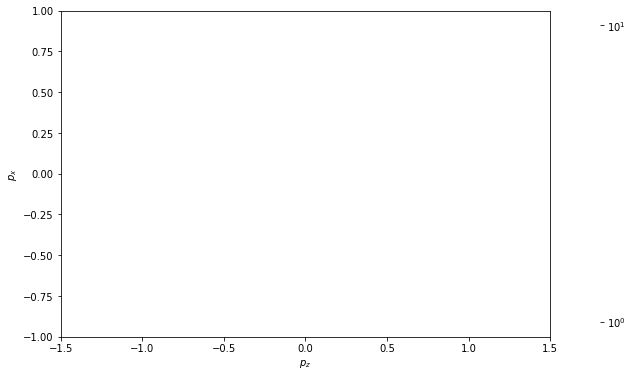

In [13]:
plot_M_grid(M_grid_stark, px_list, pz_list, log=True)

In [14]:
M_grid_stark

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

### Chiral stuffs

In [56]:
# First mirror the state in the z-axis!
chiral_clm = np.zeros_like(clm_array)
for l in range(clm_array.shape[1]):
    for m in range(-l, l+1):
        sign = 0 if m >= 0 else 1
        chiral_clm[sign, l, abs(m)] = (-1)**(l+m) * clm_array[sign, l, abs(m)]

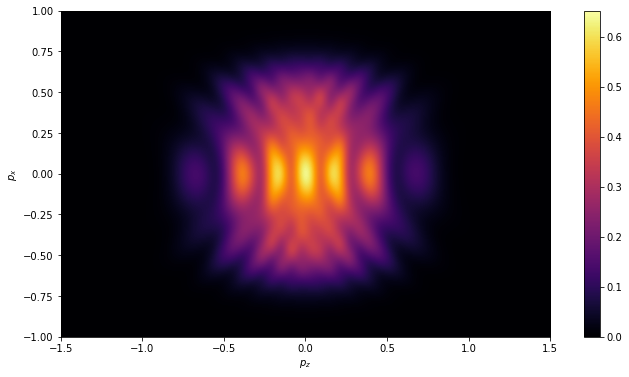

In [27]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))
plot_M_grid(M_grid, px_list, pz_list, log=False)

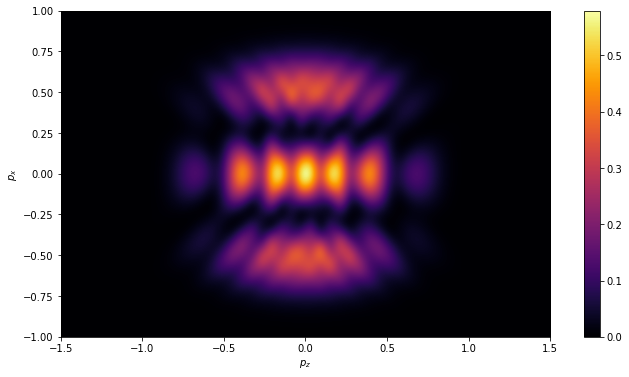

In [30]:
M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(chiral_clm))))
plot_M_grid(M_grid, px_list, pz_list, log=False)

In [55]:
N = 50
pz_list = np.linspace(-1.5, 1.5, N)
px_list = np.linspace(-1, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

In [56]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

#max_l = 3
OAM_list = [-2,-1,0,1,2]
OAM_grids = []
chiral_grids = []

for i in [1,-1]:
    OAM_grids = []

    for OAM in OAM_list:
        print(f'Calculating for OAM : {OAM}')
        SP.OAM = int(OAM)
        if i == 1:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))))
        else:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(chiral_clm)))))
    chiral_grids.append(OAM_grids[:])

Calculating for OAM : -2
Calculating for OAM : -1
Calculating for OAM : 0
Calculating for OAM : 1
Calculating for OAM : 2
Calculating for OAM : -2
Calculating for OAM : -1
Calculating for OAM : 0
Calculating for OAM : 1
Calculating for OAM : 2


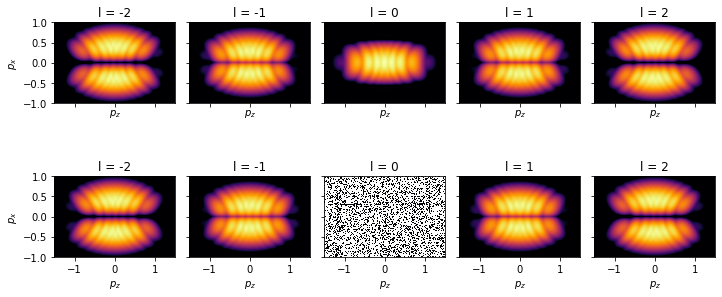

In [57]:
fig, axs = plt.subplots(2, len(OAM_list), sharey=True, sharex = True, figsize=(10,5), facecolor='white')
plt.tight_layout()
for j, OAM_grids in enumerate(chiral_grids):
    for i, Ml_grid in enumerate(OAM_grids):
        Ml2_grid = np.abs(Ml_grid)**2
        Ml_max = np.max(Ml2_grid)
        filter_list = Ml2_grid > np.max(Ml2_grid * 1e-8)
        Ml2_grid[np.logical_not(filter_list)] = 1e-8

        axs[j, i].imshow(np.flip(Ml2_grid,0), cmap='inferno', aspect=1, interpolation = 'bicubic', norm=LogNorm(vmin=Ml_max*1e-4, vmax=Ml_max),
                      extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)))
        axs[j, i].set_title(f'l = {OAM_list[i]}')
        axs[j, i].set_xlabel('$p_z$')

    axs[0,0].set_ylabel('$p_x$')
    axs[1,0].set_ylabel('$p_x$')

plt.tight_layout()

### PEVD

In [64]:
OAM_list = [-3, 3]

PEVD_grids = []

N = 100
pz_list = np.linspace(-1.5, 1.5, 2*N)
px_list = np.linspace(0, 1.4, N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

for OAM in OAM_list:
    print(f'Calculating for OAM : {OAM}')
    SP.OAM = int(OAM)
    PEVD_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))))

Calculating for OAM : -3
Calculating for OAM : 3


In [65]:
OAM_m, OAM_p = PEVD_grids
OAM2_m = np.abs(OAM_m)**2
OAM2_p = np.abs(OAM_p)**2

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD,nan=0)

filter_list1 = OAM2_m > np.max(OAM2_m*1e-4)
filter_list2 = OAM2_p > np.max(OAM2_p*1e-4)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0
#PEVD[np.logical_not(filter_list1)] = 0
#plt.imshow(np.flip(diff_grid.T), cmap='seismic', interpolation='bicubic')

/tmp/ipykernel_8317/3026794779.py:5: RuntimeWarning: invalid value encountered in true_divide
  PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))


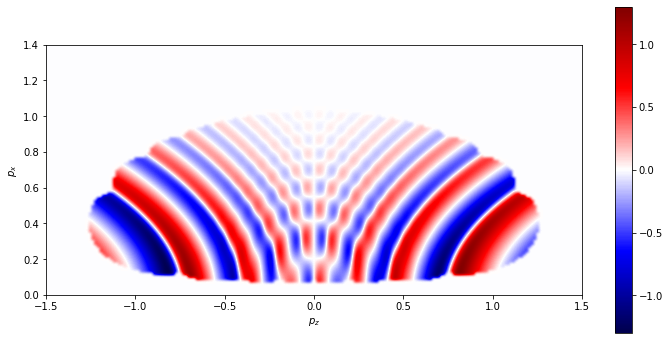

In [66]:
plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

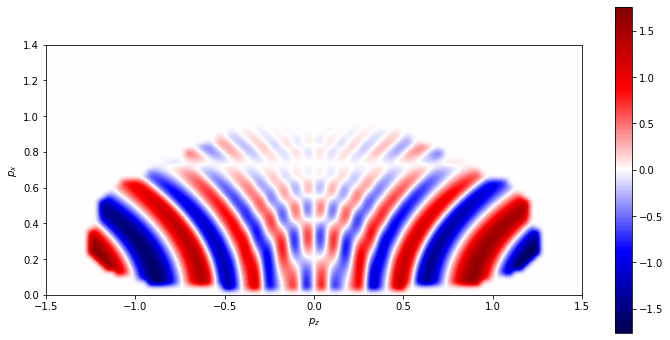

In [45]:
plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

### Rotation stuffs!

In [8]:
def euler_avg(clm_array, N_lebedev, N_gamma, px_grid, pz_grid, py=0, OAM=None):
    # Prepare the SFA calculation
    SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")
    if OAM is not None:
        SP.OAM = int(OAM)

    # First find the M(alpha_i, beta_i) where we have avg. out gamma
    M_ab_list = []  # The list of M(alpha_i, beta_i)^2 avg. over gamma
    i = 1
    time_cal = []
    time_approx = 0

    beta_list, alpha_list, w_list = load_lebedev(f'lebedev_{int(N_lebedev)}')
    gamma_list = np.linspace(0, 2*np.pi, N_gamma)

    for alpha, beta in zip(alpha_list, beta_list):
        M_gamma_list = []
        time_start = time.time()
        print(f'\rCalculating for quadrature {i}/{N_lebedev}. Approximate time left: {time_approx/60:.2f} min', end='')

        clm_rot_gamma = se.rotate_clm_several_angles([alpha], [beta], gamma_list, clm_array)

        for clm_rot_gamma_i in clm_rot_gamma:
            M_gamma_list.append(np.array(pool.starmap(SP.Mxz_List, zip(px_grid, repeat(py), pz_grid, repeat(clm_rot_gamma_i)))))

        # Integrate with trapz over gamma:
        M_ab_list.append(np.trapz(np.abs(M_gamma_list)**2, gamma_list, axis=0))

        #Stuff for finding time left:
        time_cal.append(time.time() - time_start)
        time_mean = np.mean(time_cal)
        time_approx = time_mean * (N_lebedev - i)
        i += 1

    # Now use Lebedev quad. to find the alpha and beta integral
    return 4*np.pi * np.sum([w_i * M for w_i, M in zip(w_list, M_ab_list)], axis=0)

In [23]:
N_lebedev = 38
N_gamma = 12

chiral_clm = se.mirror_clm_xy(clm_array)
#chiral_clm = se.rotate_clm(0., 0., np.pi, chiral_clm)

N = 30
pz_list = np.linspace(-1.5, 1.5, 3*N)
px_list = np.linspace(0, 1, N)
pz_grid, px_grid = np.meshgrid(pz_list, px_list)
py = 0.

In [24]:
print('Now calculating rot. avg. for normal state!')
avg_grid = euler_avg(clm_array, N_lebedev, N_gamma, px_grid, pz_grid, py, OAM=2)
#np.save('avg_grid', avg_grid)

print('\nNow starting rot. avg. for the chiral state!')
avg_grid_chiral = euler_avg(chiral_clm, N_lebedev, N_gamma, px_grid, pz_grid, py, OAM=2)
#np.save('avg_grid_chiral', avg_grid_chiral)

Now calculating rot. avg. for normal state!
Calculating for quadrature 38/38. Approximate time left: 0.31 min
Now starting rot. avg. for the chiral state!
Calculating for quadrature 38/38. Approximate time left: 0.31 min

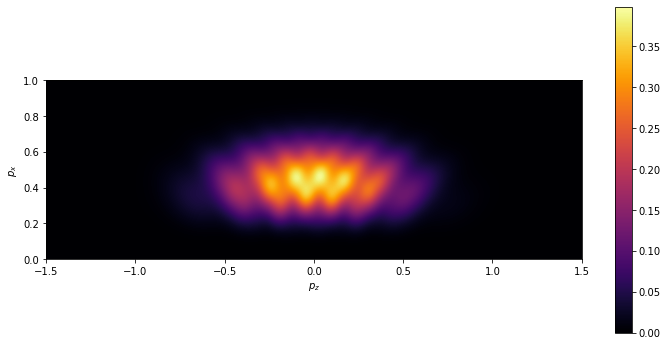

In [18]:
plot_M_grid(avg_grid/(8*np.pi), px_list, pz_list, is_square=True)

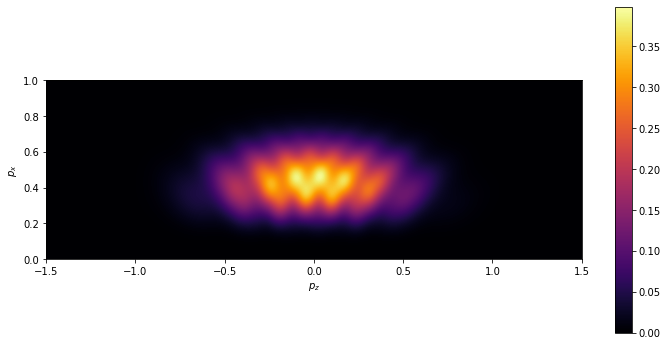

In [66]:
plot_M_grid(avg_grid/(8*np.pi), px_list, pz_list, is_square=True)

In [58]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")
OAM = 2

M_grid_list = []
M_grid_list_chiral = []
time_cal = []
time_approx = 0

print('Calculating the rotated clm_arrays!')
clm_rot_list = se.rotate_clm_several_angles(alpha_list, beta_list, gamma_list, clm_array)
#clm_rot_list_chiral = se.rotate_clm_several_angles(alpha_list, beta_list, gamma_list, chiral_clm)
print("Now calculating the PMD's.")


i = 1

SP.OAM = int(OAM)  # Remember to outcomment this if OAM selection is not wanted!

for rot_array in clm_rot_list:  #, clm_rot_list_chiral):
    time_start = time.time()
    print(f'\rCalculating for orientation {i}/{tot_angles}. Approximate time left: {time_approx/60:.2f} min', end='')

    # Things to calculate:
    M_grid_list.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(rot_array)))))
    #M_grid_list_chiral.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(rot_array_chiral)))))

    #Stuff for finding time left:
    time_cal.append(time.time() - time_start)
    time_mean = np.mean(time_cal)
    time_approx = time_mean * (tot_angles - i)
    i += 1

#np.save('rot_allene_Cl_OAM2', M_grid_list)
#np.save('rot_allene_Cl_OAM2_chiral', M_grid_list_chiral)

Calculating the rotated clm_arrays!
Now calculating the PMD's.
Calculating for orientation 11/11. Approximate time left: 0.03 min

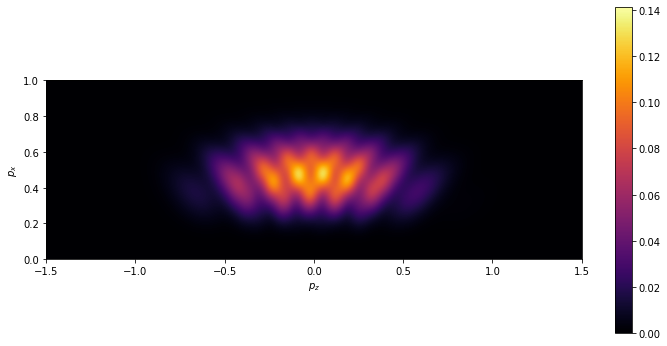

In [35]:
gamma_avg = np.trapz(np.abs(M_grid_list)**2, gamma_list, axis=0)
plot_M_grid(gamma_avg /(2*np.pi), px_list, pz_list, is_square=True)

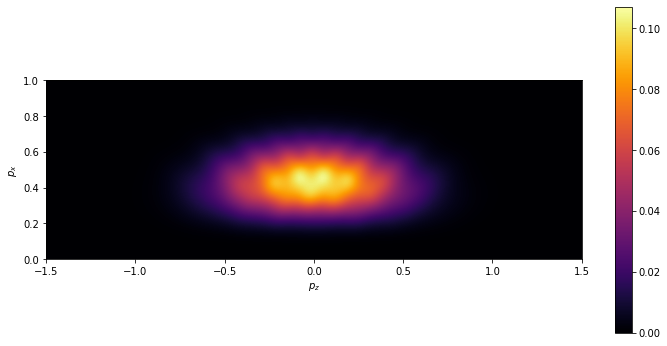

In [59]:
gamma_avg = np.trapz(np.abs(M_grid_list)**2, gamma_list, axis=0)
plot_M_grid(gamma_avg /(2*np.pi), px_list, pz_list, is_square=True)

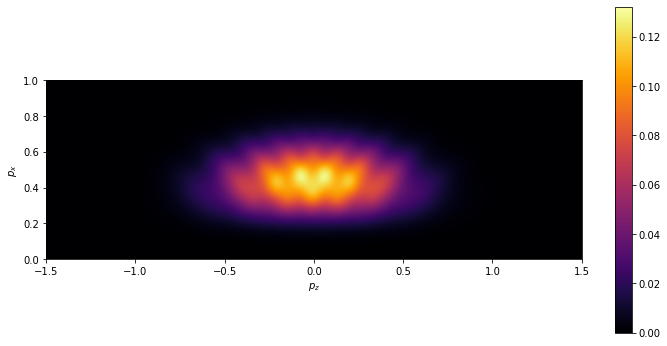

In [39]:
gamma_avg = np.trapz(np.abs(M_grid_list)**2, gamma_list, axis=0)
plot_M_grid(gamma_avg /(2*np.pi), px_list, pz_list, is_square=True)

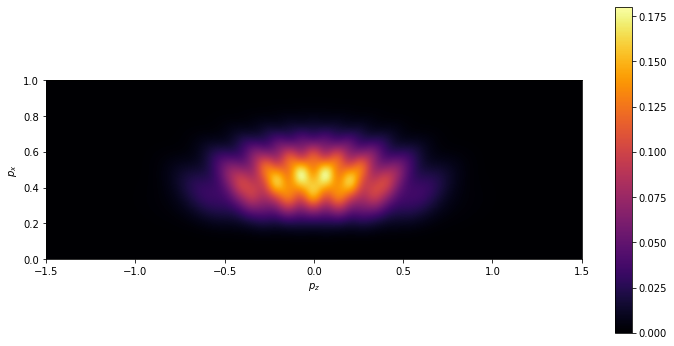

In [31]:
gamma_avg = np.trapz(np.abs(M_grid_list)**2, gamma_list, axis=0)
plot_M_grid(gamma_avg /(2*np.pi), px_list, pz_list, is_square=True)

In [28]:
M_grid_list[0].shape

(30, 90)

In [11]:
M_rot_list = np.load('avg_grid.npy')
M_rot_list_chiral = np.load('avg_grid_chiral.npy')

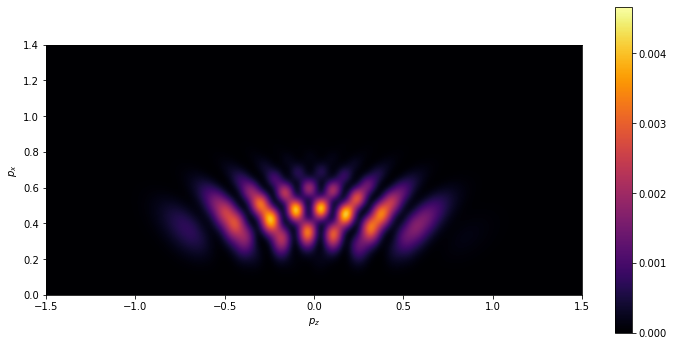

In [83]:
index = 30
plot_M_grid(M_rot_list[index], px_list, pz_list, log=False)

In [45]:
# Find the avgerage one!
M_rot_avg = np.mean(np.abs(M_rot_list)**2, axis=0)
M_rot_avg_chiral = np.mean(np.abs(M_rot_list_chiral)**2, axis=0)

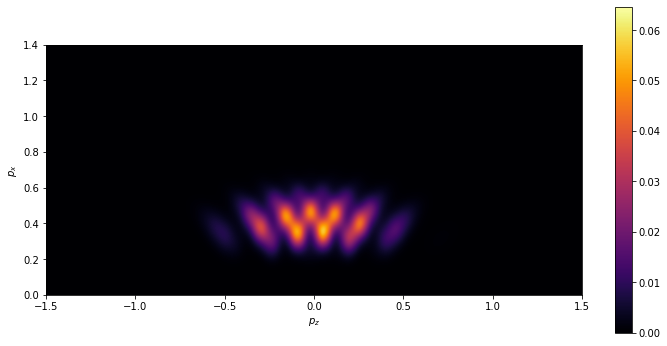

In [46]:
plot_M_grid(M_rot_avg_chiral, px_list, pz_list, is_square=False, log=False)

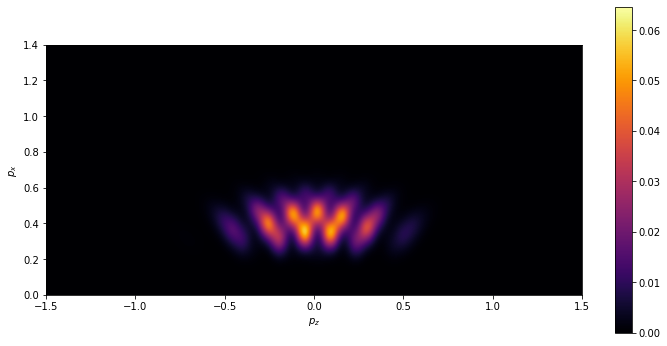

In [47]:
plot_M_grid(M_rot_avg, px_list, pz_list, is_square=False, log=False)

/tmp/ipykernel_5017/3837252085.py:4: RuntimeWarning: invalid value encountered in true_divide
  PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))


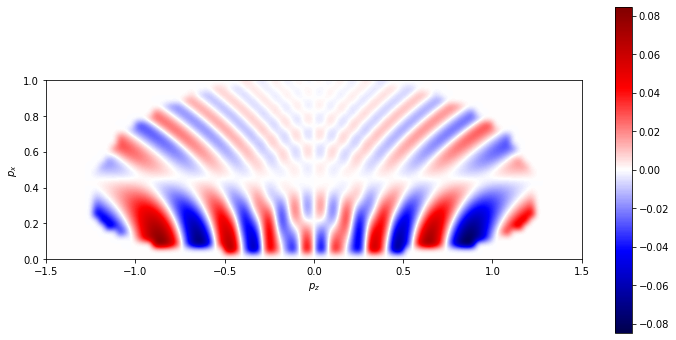

In [25]:
OAM2_p = avg_grid#np.load('avg_grid.npy') #M_rot_avg
OAM2_m = avg_grid_chiral#np.load('avg_grid_chiral.npy')#M_rot_avg_chiral

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD,nan=0)

filter_list1 = OAM2_m > np.max(OAM2_m*1e-4)
filter_list2 = OAM2_p > np.max(OAM2_p*1e-4)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0

plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

In [3]:
clm_list = [0., 0., 1., 0.]
clm_test_array = se.convert_list_to_clm_array(clm_list)

alpha_list = [0., np.pi/2, np.pi]
beta_list = [np.pi/2]
gamma_list = [0.]

clm_rot = se.rotate_clm_several_angles(alpha_list, beta_list, gamma_list, clm_test_array)

In [11]:
index = 2
plot_wavefunc(clm_rot[index])

In [21]:
theta_list, phi_list, w_list = load_lebedev('lebedev_')

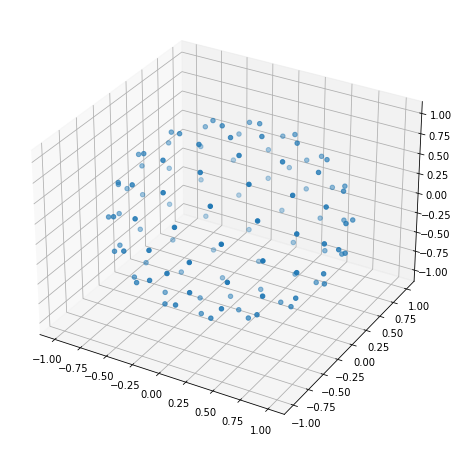

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

x_list = np.sin(theta_list) * np.cos(phi_list)
y_list = np.sin(theta_list) * np.sin(phi_list)
z_list = np.cos(theta_list)

ax.scatter(x_list, y_list, z_list)

In [ ]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")
M_grid_list = []
M_grid_list_chiral = []
time_cal = []
time_approx = 0

i = 1
for alpha in alpha_list:
    for beta in beta_list:
        for gamma in gamma_list:
            time_start = time.time()
            print(f'\rCalculating for orientation {i}/{tot_angles}. Approximate time left: {time_approx/60:.2f} min', end='')
            clm_rot = se.rotate_clm(alpha, beta, gamma, clm_array)
            clm_rot_chiral = se.rotate_clm(alpha, beta, gamma, chiral_clm)
            M_grid_list.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_rot)))))
            M_grid_list_chiral.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_rot_chiral)))))

            #Stuff for finding time left:
            time_cal.append(time.time() - time_start)
            time_mean = np.mean(time_cal)
            time_approx = time_mean * (tot_angles - i)
            i += 1

np.save('M_rot_list', M_grid_list)
np.save('M_rot_list_chiral', M_grid_list_chiral)